# 2018-05-17 - Convolutional + BiRNN 

# CNN + BiRNN for MC
![Could not display RNN picture](http://slideplayer.com/slide/10066142/32/images/8/Recurrent+Neural+Networks.jpg)
Les réseaux de neurones bidirectionnels ont l'avantage sur les RNN qu'ils peuvent représenter des informations dans les deux sens, forward et backward, ce qui dans noter cas permet de mimer les connexions latérales de V1. Le traitement unitaire des colonnes de V1 est représenté par un CNN.

In [53]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

###################################################################################

# Hyper-parameters
sequence_length = 22
input_size = 22
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 100
learning_rate = 0.003

###################################################################################

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.conv = nn.Conv2d(1,16,20)
        self.pool = nn.MaxPool2d(2,2)
        self.drop = nn.Dropout(0.2)

        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        #print('Input %s' % str(x.size()))

        x = self.pool(F.relu(self.conv(x)))
        #print('Convoluted %s' % str(x.size()))

        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0).cuda()
        c0 = Variable(c0).cuda()
        
        x = x[:,-1,:,:]
        #print('Resized for RNN %s' % str(x.size()))
        
        # LSTM forward
        out, _ = self.rnn(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        #print('After RNN %s' % str(out.size()))
        
        #Dropout
        out = self.drop(out)
        # LSTM output
        out = self.fc(out[:, -1, :])
        #print('Reshaped for output %s \n'%  str(out.size()))

        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()
print(model)

###################################################################################

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###################################################################################

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()

        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1
            

BiRNN(
  (rnn): LSTM(22, 128, num_layers=2, batch_first=True, bidirectional=True)
  (conv1): Conv2d(1, 8, kernel_size=(20, 20), stride=(1, 1))
  (conv2): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2)
  (fc): Linear(in_features=126, out_features=16, bias=True)
)
Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/100], Step [100/480], Loss: 2.7877
Epoch [1/100], Step [200/480], Loss: 2.7800
Epoch [1/100], Step [300/480], Loss: 2.6643
Epoch [1/100], Step [400/480], Loss: 2.7009
Epoch [2/100], Step [100/480], Loss: 2.7512
Epoch [2/100], Step [200/480], Loss: 2.7954
Epoch [2/100], Step [300/480], Loss: 2.7160


Process Process-746:
Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 101, in __getitem__
    sample = self.loader(path)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 147, in default_loader
    return pil_loader(path)

KeyboardInterrupt: 

Test Accuracy of the model on the test images: 87 %


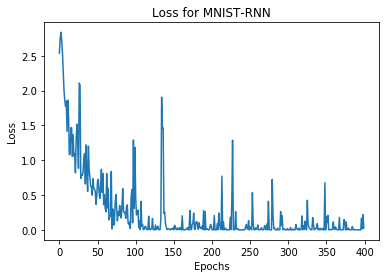

In [16]:
correct = 0
total = 0

model.eval() 

for images, labels in test_loader:
    images = Variable(images).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()

# Test avec CNN-LSTM-CNN
Ca modelerait un peu mieux l'architecture du cortex visuel selon moi, avec deux couches de 8 CNN qui représentent 16 orientations au total et la connexion latérale par LSTM au milieu.

In [56]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

###################################################################################

# Hyper-parameters
sequence_length = 22
input_size = 22
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 100
learning_rate = 0.003

###################################################################################

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout = 0.2)
        self.conv1 = nn.Conv2d(1,8,20)
        self.conv2 = nn.Conv2d(1,8,4)
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop = nn.Dropout(0.2)

        self.fc = nn.Linear(126 , 16)  # 2 for bidirection
    
    def forward(self, x):
        #print('Input %s' % str(x.size()))

        out = self.pool1(F.relu(self.conv1(x)))
        #print('Convoluted %s' % str(x.size()))

        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0).cuda()
        c0 = Variable(c0).cuda()
        
        out = out[:,-1,:,:]
        #print('Resized for RNN %s' % str(x.size()))
        
        # LSTM forward
        out, _ = self.rnn(out, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        #print('After RNN %s' % str(out.size()))
        
        out = out.unsqueeze(1)
        #print(out.size())
        out = self.pool2(F.relu(self.conv2(out)))
        #print(out.size())
        out = out[:,-1,:,:]
        #Dropout
        #out = self.drop(out)
        #print(out.size())
        
        out = out[:,-1,:]
        # LSTM output
        out = self.fc(out)
        #print('Reshaped for output %s \n'%  str(out.size()))

        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()
print(model)

###################################################################################

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###################################################################################

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1
            

BiRNN(
  (rnn): LSTM(22, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (conv1): Conv2d(1, 8, kernel_size=(20, 20), stride=(1, 1))
  (conv2): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2)
  (fc): Linear(in_features=126, out_features=16, bias=True)
)
Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/100], Step [100/480], Loss: 2.7285
Epoch [1/100], Step [200/480], Loss: 2.6308
Epoch [1/100], Step [300/480], Loss: 2.1274
Epoch [1/100], Step [400/480], Loss: 2.0105
Epoch [2/100], Step [100/480], Loss: 1.8744
Epoch [2/100], Step [200/480], Loss: 1.8917
Epoch [2/100], Step [300/480], Loss: 1.6214
Epoch [2/100], Step [400/480], Loss: 2.2849
Epoch [3/100], Step [100/480], Loss: 2.2953
Epoch [3/100], Step [200/480], Loss: 1.9627
Epoch [3/100], Step [300/480], Loss: 2.4678
Epoch [3/100], Step [400/480], Loss: 1.6153
Epoch [4/100], Step [100/480], Loss: 2.5157
Epoch [4/100], Step [200/480], Loss: 2.0347
Epoch [4/100], Step [300/480], Loss: 2.5224
Epoch [4/100], Step [400/480], Loss: 1.7225
Epoch [5/100], Step [100/480], Loss: 1.6730
Epoch [5/100], Step [200/480], Loss: 1.4673
Epoch [5/100], Step [300/480], Loss: 1.3352
Epoch [5/100], Step [400/480], Loss: 1.7105
Epoch [6/100], Step [100/480], Loss: 1.4243
Epoch [6/100], Step [200/480], Loss: 1.4735
Epoch [6/100], Step [300/480], L

Epoch [46/100], Step [400/480], Loss: 0.0002
Epoch [47/100], Step [100/480], Loss: 0.0842
Epoch [47/100], Step [200/480], Loss: 0.1766
Epoch [47/100], Step [300/480], Loss: 0.0020
Epoch [47/100], Step [400/480], Loss: 0.0525
Epoch [48/100], Step [100/480], Loss: 0.0157
Epoch [48/100], Step [200/480], Loss: 0.0806
Epoch [48/100], Step [300/480], Loss: 0.2117
Epoch [48/100], Step [400/480], Loss: 0.1742
Epoch [49/100], Step [100/480], Loss: 0.0175
Epoch [49/100], Step [200/480], Loss: 0.0472
Epoch [49/100], Step [300/480], Loss: 0.0474
Epoch [49/100], Step [400/480], Loss: 0.1699
Epoch [50/100], Step [100/480], Loss: 0.0047
Epoch [50/100], Step [200/480], Loss: 0.0030
Epoch [50/100], Step [300/480], Loss: 0.0344
Epoch [50/100], Step [400/480], Loss: 0.0681
Epoch [51/100], Step [100/480], Loss: 0.1410
Epoch [51/100], Step [200/480], Loss: 0.0187
Epoch [51/100], Step [300/480], Loss: 0.0014
Epoch [51/100], Step [400/480], Loss: 0.0157
Epoch [52/100], Step [100/480], Loss: 0.0075
Epoch [52/

Epoch [92/100], Step [300/480], Loss: 0.0062
Epoch [92/100], Step [400/480], Loss: 0.0309
Epoch [93/100], Step [100/480], Loss: 0.0010
Epoch [93/100], Step [200/480], Loss: 0.0516
Epoch [93/100], Step [300/480], Loss: 0.0014
Epoch [93/100], Step [400/480], Loss: 2.3613
Epoch [94/100], Step [100/480], Loss: 0.0079
Epoch [94/100], Step [200/480], Loss: 0.0018
Epoch [94/100], Step [300/480], Loss: 0.0005
Epoch [94/100], Step [400/480], Loss: 0.0260
Epoch [95/100], Step [100/480], Loss: 0.0094
Epoch [95/100], Step [200/480], Loss: 0.0598
Epoch [95/100], Step [300/480], Loss: 0.0021
Epoch [95/100], Step [400/480], Loss: 0.0124
Epoch [96/100], Step [100/480], Loss: 0.0038
Epoch [96/100], Step [200/480], Loss: 0.0047
Epoch [96/100], Step [300/480], Loss: 0.0027
Epoch [96/100], Step [400/480], Loss: 0.1784
Epoch [97/100], Step [100/480], Loss: 0.0006
Epoch [97/100], Step [200/480], Loss: 0.0029
Epoch [97/100], Step [300/480], Loss: 0.0036
Epoch [97/100], Step [400/480], Loss: 0.0015
Epoch [98/

Test Accuracy of the model on the test images: 86 %


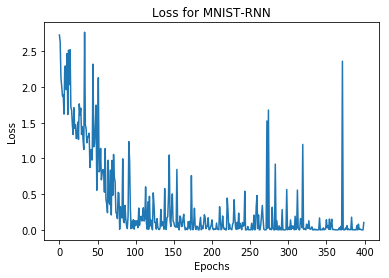

In [57]:
correct = 0
total = 0

model.eval() 

for images, labels in test_loader:
    images = Variable(images).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()